In [1]:
from model_phantom_DB import *
from linares_plot import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

For all the matrice data : each row is one trial, each column is one neuron. 
For the same row the trial data may not be collected on the same trial since data might are collected on different days.

cuerate: firing rate during 1st visual stimuli(cue) presentation.

cuerate_stim: firing rate during 1st cue presentation with NB stimulation. 

cdrate: firing rate during the 1st delay after 1st cue presentation. 

cdrate_stim: firing rate during the 1st delay after cue presentation  with NB stimulation.  
 
samplerate: firing rate during 2nd visual stimuli(sample) presentation. 

samplerate_stim: firing rate during sample presentation with NB stimulation. 

sdrate: firing rate during the delay after sample presentation. 

sdrate_stim: firing rate during the delay after sample presentation with NB stimulation. 

g1: location of 1st visual stimuli(cue)
 value -1 means no visual stimuli presented.
 value [1 2 3 4 5] are  relative locaions, such as [0 45 90 135 180], or [ 45 90 135 180 225], etc.
 The real locations depended on neurons' receptive field.
 According to our behavioral paradigm, the cue will only be presented on locaion [1 5]. that is two opposite locations, such as [0 180], [45 225], etc.
 For each neuron, thoes value([1:5]) refer to the same locations.

g2: location of 2nd visual stimuli(sample)
  Sample can show up in all five possible locations([1:5]) or not presented(-1).

g3: task type for each trial, eg. saccade to 1st (value 1), or saccade to 2nd(value 2).


In [2]:
from scipy.io import loadmat 
file = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Classifiy_data_odrdistvar_allNeurons_reverse.matlab'
data = loadmat(file)
data.keys()

dict_keys(['__globals__', 'sdrate', 'g2_stim', 'g1', 'cuerate_stim', 'samplerate_stim', '__version__', 'g3_stim', 'g1_stim', 'cuerate', '__header__', 'g3', 'cdrate_stim', 'samplerate', 'g2', 'cdrate', 'sdrate_stim'])

In [3]:
rate_d1_off = data['cdrate']
positions_stim_off= data['g1'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

rate_d1_on = data['cdrate_stim']
positions_stim_on= data['g1_stim'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

In [8]:
number_neurons = np.shape(rate_d1_off)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='OFF'
reps_ = 50# 300 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []


for Neuron in range(number_neurons):
    print(Neuron)
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_off.append(fpr["macro"])
        tpr_mean_off.append(tpr["macro"])
        roc_mean_off.append(roc_auc["macro"])
    ###
    ###
    ###

    
    

0
1


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


2
3


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


4
5

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



6


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


7
8


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


9
10


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


11
12


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


13
14


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


15


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


16
17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


18
19


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


20
21

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



22


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


24
25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages

26
27
28
29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


30
31


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


32
33


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


34
35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


37


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


38


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


39


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


40
41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


42
43
44

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



45


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


46
47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


48
49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


50
51


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


52


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


53


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


54


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

55
56


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

57


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

58
59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


60
61


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


62


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


63
64

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



65
66


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


67
68

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



69


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


70


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

71
72
73


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


74


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


75


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


76


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

77


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

78


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

79
80
81


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


82
83


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


84
85
86


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


87


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


88


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


89


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


90
91


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


92
93


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


94
95


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


96
97


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


98


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


99
100


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

101
102


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


103
104


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


105
106


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


107
108


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


109
110


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


111
112


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


113
114


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


115
116


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


117
118


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


119
120


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


121


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


122


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


123


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


124
125


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


126
127


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


128
129


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


130
131


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


132
133


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


134
135


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


136
137


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


138


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

139
140
141
142


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


143
144


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


145
146


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


147
148


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


149
150


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


151
152


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


153
154


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


155
156


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

157


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


158


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


159


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


160


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


161
162


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


163
164


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


165
166


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

167
168


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


169
170


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


171
172


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


173
174


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


175


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

176
177


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


178
179


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


180
181


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


182
183


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


184
185


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


186
187


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


188
189


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


190
191

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



192


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


193
194
195


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


196
197


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


198
199


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

200
201


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

202
203


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


204
205


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


206
207


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


208
209


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


210
211


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


212
213


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


214
215
216


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


217
218


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


219
220


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


221
222


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


223
224


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


225
226


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


227
228


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


229
230


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


231
232


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


In [9]:
number_neurons = np.shape(rate_d1_on)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='ON'
reps_ = 50#300 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []


for Neuron in range(number_neurons):
    print(Neuron)
    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_on.append(fpr["macro"])
        tpr_mean_on.append(tpr["macro"])
        roc_mean_on.append(roc_auc["macro"])
    ###
    ###
    ###

    

0
1


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\

2
3


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true

4
5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false

6
7


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site

8
9
10
11


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


12
13


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


14
15


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


16
17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

18
19


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


20
21


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


22
23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


24
25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


26
27


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


28
29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


30
31


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


32
33


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


34
35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


37


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


38
39


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


40
41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


42
43


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


44
45


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


46
47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


48
49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


50
51


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


52


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

53
54


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


55


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

56


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

57


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

58
59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


60
61


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


62
63


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


64
65


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


66
67


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


68
69


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


70


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


71
72


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


73
74


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

75
76


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


77


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

78


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

79
80


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


81
82


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

83
84


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


85
86


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


87
88


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


89
90


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


91
92


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


93
94


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


95
96


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


97
98


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


99
100


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


101
102


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


103
104


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


105
106


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


107
108


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


109
110


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


111
112


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


113
114


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


115
116


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


117
118


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


119
120


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\

121
122


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: Undefined

123
124


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


125
126


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


127
128


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: Undefined

129


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: Undefined

130
131


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


132
133


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


134
135
136


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


137
138


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

139
140
141
142


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


143


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: inval

144
145
146


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


147
148


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


149
150


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


151
152


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


153


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


154
155


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


156


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

157


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

158
159


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


160
161


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


162
163


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


164
165


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


166
167


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, fals

168
169


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


170
171


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

172
173


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


174


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


175


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


176
177


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: U

178
179


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site

180
181


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


182
183


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


184
185


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


186
187


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


188
189


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


190
191


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


192
193


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, fals

194
195


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site

196


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, fals

197
198
199


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, fals

200
201


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

202
203


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

204
205


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

206
207


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

208
209


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

210
211


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\

212
213


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: Und

214
215


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\

216
217


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site

218
219


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, fals

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site

220
221


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true

222
223


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true

224


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site

225
226


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site

227
228


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

229
230
231
232


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

In [66]:
np.nanmean(roc_mean_on)

0.5655385647019296

In [67]:
np.nanmean(roc_mean_off)

0.6113187601302598

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


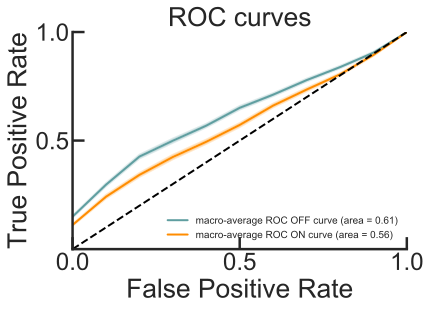

In [28]:
%config InlineBackend.figure_format = 'svg' ## 'svg'

plt.figure()
lw = 2

#fpr_mean_off = np.concatenate(fpr_mean_off)
#tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(1)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off)))



#fpr_mean_on = np.concatenate(fpr_mean_on)
#tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(1)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


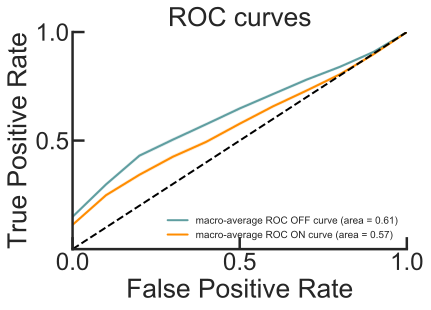

In [72]:
%config InlineBackend.figure_format = 'svg' ## 'svg'

plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(1)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(1)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

TypeError: unhashable type: 'numpy.ndarray'

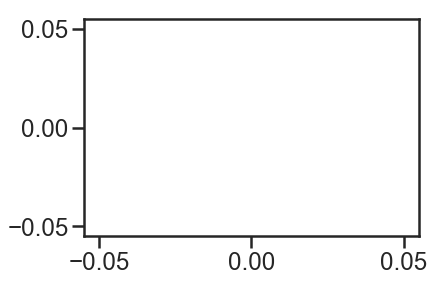

In [12]:
plt.figure()
lw = 2

# fpr_mean_off = np.concatenate(fpr_mean_off)
# tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off)))



# fpr_mean_on = np.concatenate(fpr_mean_on)
# tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

#scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [4]:
number_neurons = np.shape(rate_d1_off)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='OFF'
reps_ = 50# 300 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_off_all = []
tpr_mean_off_all = []
roc_mean_off_all = []


for Neuron in range(number_neurons):
    print(Neuron)
    fpr_mean_off = []
    tpr_mean_off = []
    roc_mean_off = []
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_off.append(fpr["macro"])
        tpr_mean_off.append(tpr["macro"])
        roc_mean_off.append(roc_auc["macro"])
    ###
    ###
    ### ## save the cross validate mean value for each neuron
    df_mean = pd.DataFrame({'fpr': np.concatenate(fpr_mean_off), 'tpr': np.concatenate(tpr_mean_off)})
    df_mean = df_mean.round(2)
    fpr_n=[]
    for unique_tpr in df_mean.tpr.unique():
        fpr_n.append(df_mean.loc[df_mean['tpr']==unique_tpr, 'fpr'].mean() )

    fpr_mean_off_all.append( np.array(fpr_n) )
    tpr_mean_off_all.append( df_mean.tpr.unique() )
    roc_mean_off_all.append(np.nanmean(roc_mean_off) )

    

0


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


1


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


3


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


4


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


6


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


7


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


8


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


10


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


11


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


12


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


13


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


14


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


15


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


16


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


18


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


19


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


20


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


21


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


22


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


24


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


26


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


27


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


28


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


30


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


31


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


32


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


33


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


34


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


37


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


38


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


39


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


40


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


42


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


43


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


44


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


45


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


46


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


48


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


50


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


51


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


52


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


53


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


54


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

55


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


56


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

57


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

58
59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


60


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


61


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


62


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


63


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


64


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


65


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


66


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


67


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


68


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


69


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


70


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

71


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


72


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


73


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


74


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


75


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


76


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

77


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

78


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

79
80
81

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



82


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


83


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


84


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


85


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


86


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


87


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


88


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


89


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


90


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


91


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


92


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


93


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


94


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


95


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


96


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


97


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


98


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


99


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


100


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

101
102


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


103


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


104


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


105


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


106


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


107


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


108


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


109


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


110


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


111


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


112


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


113


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


114


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


115


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


116


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


117


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


118


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


119


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


120


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


121


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


122


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


123


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


124


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


125


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


126


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


127


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


128


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


129


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


130


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


131


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


132


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


133


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


134


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


135


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


136


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


137


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


138


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

139


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


140


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


141


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


142


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


143


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


144


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


145


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


146


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


147


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


148


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


149


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


150


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


151


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


152


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


153


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


154


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


155


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


156


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


157


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


158


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


159


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


160


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


161


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


162


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


163


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


164


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


165


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


166


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

167


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


168


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


169
170

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



171


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


172


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


173


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


174


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


175


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

176
177


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


178


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


179


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


180


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


181


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


182


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


183


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


184


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


185


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


186


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


187


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


188


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


189


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


190


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


191


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


192


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


193


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


194


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


195


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


196


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


197


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


198


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


199


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

200
201


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


202
203


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


204


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


205
206
207

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



208


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


209


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


210


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


211


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


212


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


213


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


214


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


215


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


216
217


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


218
219

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



220


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


221
222

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



223
224

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



225


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


226


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


227
228

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater



229


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


230


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


231


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


232


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


In [ ]:
number_neurons = np.shape(rate_d1_on)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='ON'
reps_ = 50# 300 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_on_all = []
tpr_mean_on_all = []
roc_mean_on_all = []


for Neuron in range(number_neurons):
    print(Neuron)
    fpr_mean_on = []
    tpr_mean_on = []
    roc_mean_on = []
    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_on.append(fpr["macro"])
        tpr_mean_on.append(tpr["macro"])
        roc_mean_on.append(roc_auc["macro"])
    ###
    ###
    ### ## save the cross validate mean value for each neuron
    df_mean = pd.DataFrame({'fpr': np.concatenate(fpr_mean_on), 'tpr': np.concatenate(tpr_mean_on)})
    df_mean = df_mean.round(2)
    fpr_n=[]
    for unique_tpr in df_mean.tpr.unique():
        fpr_n.append(df_mean.loc[df_mean['tpr']==unique_tpr, 'fpr'].mean() )

    fpr_mean_on_all.append( np.array(fpr_n) )
    tpr_mean_on_all.append( df_mean.tpr.unique() )
    roc_mean_on_all.append(np.nanmean(roc_mean_on) )

0


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


1


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\Dav

2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


3
4


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeW

6
7


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


8


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


10


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


11


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


12


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


13


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


14


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


15


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


16


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


18


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


19


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


20


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


21


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


22


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


24


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


26


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


27


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


28


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


30


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


31


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


32


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


33


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


34


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


37


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


38


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


39


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


40


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


42


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


43


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


44


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


45


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


46


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


48


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


50


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


51


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


52


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

53
54


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


55


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

56


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

57


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

58
59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


60


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


61


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


62


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


63


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


64


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


65


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


66


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


67


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


68


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


69


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


70


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


71


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


72


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


73


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


74


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


75


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


76


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


77


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

78


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

79


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


80


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


81


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


82


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\metrics\ranking.py:643: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


83


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


84


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


85


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


86


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


87


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


88


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


89


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


90


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


91


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


92


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


93


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


94


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


95


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


96


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


97


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


98


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


99


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


100


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


101


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


102


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


103


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


104


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


105


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


106


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


107


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


108


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


109


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


110


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


111


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


112


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


113


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


114


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


115


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


116


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


117


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


In [6]:
fpr_off = np.concatenate(fpr_mean_off_all)
tpr_off = np.concatenate(tpr_mean_off_all)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_off, 'tpr_mean': tpr_off})
#df_ROC_OFF = df_ROC_OFF.round(2)


In [7]:
fpr_on = np.concatenate(fpr_mean_on_all)
tpr_on = np.concatenate(tpr_mean_on_all)
df_ROC_ON = pd.DataFrame({'tpr_mean': tpr_on, 'fpr_mean': fpr_on})
#df_ROC_ON = df_ROC_ON.round(2)

In [8]:
df_ROC_ON.head()

,fpr_mean,tpr_mean
0,0.066607,0.00
1,0.905085,1.00
2,0.214286,0.25
3,0.500000,0.75
4,0.518889,0.67


In [9]:
fpr_n=[]
for unique_tpr in df_ROC_ON.tpr_mean.unique():
    fpr_n.append(df_ROC_ON.loc[df_ROC_ON['tpr_mean']==unique_tpr, 'fpr_mean'].mean() )

    
df_ROC_ON2= pd.DataFrame({'fpr_mean': np.array(fpr_n) , 'tpr_mean': df_ROC_ON.tpr_mean.unique()})


####

fpr_n=[]
for unique_tpr in df_ROC_OFF.tpr_mean.unique():
    fpr_n.append(df_ROC_OFF.loc[df_ROC_OFF['tpr_mean']==unique_tpr, 'fpr_mean'].mean() )

    
df_ROC_OFF2= pd.DataFrame({'fpr_mean': np.array(fpr_n) , 'tpr_mean': df_ROC_OFF.tpr_mean.unique()})


In [10]:
df_ROC_OFF2.head()

,fpr_mean,tpr_mean
0,0.030595,0.00
1,0.911440,1.00
2,0.199267,0.25
3,0.129878,0.12
4,0.316804,0.43


In [23]:
df_ROC_ON_p = df_ROC_ON2.round(1)
df_ROC_OFF_p = df_ROC_OFF2.round(1)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


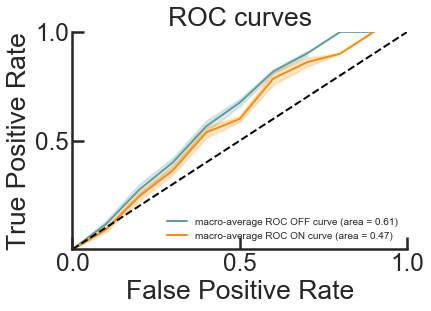

In [24]:
sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF_p, color='cadetblue', 
             linestyle='--', linewidth=2, ci=69,
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off_all)))



sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON_p, color='darkorange', 
             linestyle='--', linewidth=2, ci=69,
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on_all)))


plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

In [26]:
len(roc_mean_on_all)

233

In [ ]:
scipy.stats.ttest_ind(roc_mean_on_all, roc_mean_off_all)

In [ ]:
plt.hist(roc_mean_on_all)

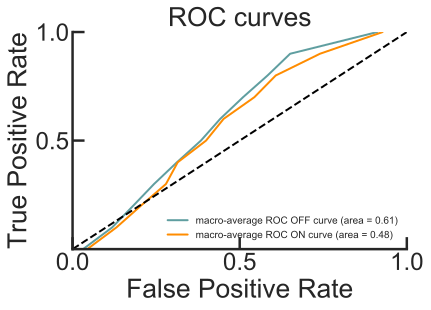

In [191]:
sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF2, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off_all)))



sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON2, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on_all)))


plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


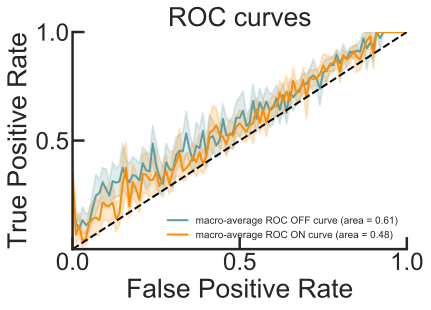

In [166]:
sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off_all)))



sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on_all)))


plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

In [ ]:
plt.figure()
lw = 2

# fpr_mean_off = np.concatenate(fpr_mean_off)
# tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off)))



# fpr_mean_on = np.concatenate(fpr_mean_on)
# tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')


In [81]:
fpr_mean_off_all

[array([0.0383908 , 0.752     , 0.81666667, 0.98963303, 0.4075    ,
        0.725     , 0.38380952, 0.83      , 0.15857143, 0.23190476,
        0.625     , 0.        , 0.776     , 0.79333333, 0.04833333,
        0.29166667, 0.3       , 0.68333333, 0.8       , 0.6       ,
        0.        , 0.43      , 0.25      , 0.30666667, 0.57      ,
        0.66333333, 0.11      , 0.83      , 0.28181818, 0.43      ]),
 array([0.07554348, 0.10272727, 0.95991525, 0.34615385, 0.73333333,
        0.27451613, 0.516875  , 0.65217391, 0.7125    , 0.24692308,
        0.60571429, 0.14421053, 0.40846154, 0.60642857, 0.75153846,
        0.82428571, 0.50944444, 0.33      , 0.0825    , 0.72333333,
        0.75      , 0.134     , 0.44333333, 0.68888889, 0.8       ,
        0.6       , 0.83      , 0.        , 0.88      ]),
 array([0.24516129, 0.73726563, 0.29217391, 0.        , 0.08428571,
        0.10142857, 0.05666667, 0.17      , 0.332     , 0.11428571,
        0.33461538, 0.07761905, 0.15947368, 0.05142857, 

In [68]:
tpr_mean_off

[array([0.125, 0.375, 1.   ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.22222222, 0.66666667, 1.        ]),
 array([0.   , 0.125, 0.375, 1.   ]),
 array([0., 1.]),
 array([0.25 , 0.25 , 0.625, 1.   ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.125, 0.25 , 0.625, 1.   ]),
 array([0. , 0. , 0.5, 1. ]),
 array([0.33333333, 0.44444444, 1.        ]),
 array([0.        , 0.11111111, 0.66666667, 1.        ]),
 array([0.   , 0.125, 0.5  , 1.   ]),
 array([0., 1.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([0., 1.]),
 array([0.   , 0.625, 1.   ]),
 array([0.125, 0.5  , 0.75 , 1.   ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.11111111, 1.        ]),
 array([0., 1.]),
 array([0.22222222, 0.33333333, 0.55555556, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.1, 0.3, 0.6, 1. ]),
 array([0., 1.]),
 arr

In [76]:
df_mean = pd.DataFrame({'fpr': np.concatenate(fpr_mean_off), 'tpr': np.concatenate(tpr_mean_off)})
df_mean = df_mean.round(2)

fpr_n=[]

for unique_tpr in df_mean.tpr.unique():
    fpr_n.append(df_mean.loc[df_mean['tpr']==unique_tpr, 'fpr'].mean() )

np.array(fpr_n)

array([0.139     , 0.64      , 1.        , 0.00825   , 0.165     ,
       0.62      , 0.2       , 0.75      , 0.5975    , 0.23833333,
       0.47666667, 0.07      , 0.88      , 0.57      , 0.05666667,
       0.5       , 0.55333333, 0.165     , 0.2       , 0.83      ,
       0.615     , 0.33      , 0.67      ])

In [77]:
df_mean.tpr.unique()

array([0.12, 0.38, 1.  , 0.  , 0.22, 0.67, 0.25, 0.62, 0.5 , 0.33, 0.44,
       0.11, 0.75, 0.56, 0.1 , 0.3 , 0.6 , 0.08, 0.2 , 0.7 , 0.29, 0.14,
       0.43])

In [73]:
df_mean.loc[df_mean['tpr']==0, 'fpr'].mean()

0.00825

In [51]:
df_mean.tpr.unique()

array([0.12, 0.38, 1.  , 0.  , 0.22, 0.67, 0.25, 0.62, 0.5 , 0.33, 0.44,
       0.11, 0.75, 0.56, 0.1 , 0.3 , 0.6 , 0.08, 0.2 , 0.7 , 0.29, 0.14,
       0.43])

In [43]:
fpr_mean_off

[array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.28571429, 0.71428571, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.14285714, 0.57142857, 1.        ]),
 array([0., 1.]),
 array([0., 1.])]

In [44]:
tpr_mean_off

[array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.22222222, 0.77777778, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.11111111, 0.22222222, 0.66666667, 1.        ]),
 array([0., 1.]),
 array([0., 1.])]

In [41]:
df_mean.fpr.unique()

array([0.  , 1.  , 0.29, 0.71, 0.14, 0.57])

In [38]:
np.concatenate(tpr_mean_off)

array([0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.22222222, 0.77777778, 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.11111111, 0.22222222, 0.66666667, 1.        ,
       0.        , 1.        , 0.        , 1.        ])

In [34]:
tpr_mean_off

[array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.22222222, 0.77777778, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.11111111, 0.22222222, 0.66666667, 1.        ]),
 array([0., 1.]),
 array([0., 1.])]

In [35]:
roc_mean_off

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5714285714285714, 0.5, 0.5]

In [36]:
fpr["macro"]

array([0., 1.])